
<br>
<font>
<div dir=ltr align=center>
<font color=0F5298 size=7>
    System 2 - Homework 1<br>
<font color=2565AE size=5>
    Spring 2025<br>
<font color=3C99D size=5>
    Symbolic Regression <br>


---

### Student Number = 401105923

### Full Name = Radin Cheraghi

---

# Introduction

This notebook explores two methods for performing symbolic regression, focusing on both traditional and modern AI-driven approaches:

## 1. EQL-Based Symbolic Regression  
The first approach we implement is based on **Equation Learner (EQL)**, a neural network-based symbolic regression technique. EQL leverages neural networks with activation functions that encourage the discovery of symbolic expressions, making it a differentiable and trainable approach for learning equations directly from data. This method helps in bridging the gap between deep learning and symbolic reasoning.

## 2. Seq2Seq-Based Symbolic Regression with Transformers
A more recent and powerful approach to symbolic regression leverages Sequence-to-Sequence (Seq2Seq) models using Transformers. In this method, we frame symbolic regression as a translation problem, where the input consists of numerical data points and the output is a corresponding mathematical expression. By training a Transformer model on pairs of input data and symbolic expressions, we can enable it to generalize and infer underlying symbolic patterns. This approach benefits from the self-attention mechanism, allowing it to capture long-range dependencies in mathematical structures effectively.


# Datasets

We use two datasets to evaluate our methods:

- **Dataset 1:** This dataset is provided in the notebook, and its underlying mathematical formula is explicitly given. It serves as a reference to assess the performance of different symbolic regression approaches. The expression we consider is: `2 * x + np.sin(x) + x * np.sin(x)`.
  
- **Dataset 2:** This dataset is also provided with the notebook, but its underlying mathematical relationship is hidden. Throughout different parts of the notebook, you will attempt to uncover the equation governing this dataset. Your responses will be evaluated based on how accurately you recover the true formula.

By working through both datasets, we aim to test the robustness and accuracy of various symbolic regression techniques while providing an engaging and exploratory learning experience.

# Import Libraries

In [2]:
import pickle
import numpy as np
import sympy as sp
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from inspect import signature
import time
from tqdm.auto import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sympy
import glob
import time
import signal
import random
import warnings
import json
import re

warnings.filterwarnings('ignore')

# Generate Dataset

In [4]:
def generate_data(func, N, range_min=-2, range_max=2, noise_std=0.1):
    """
    Generates a dataset by evaluating the given function on random input values with added noise.

    Parameters:
    func (callable): A function that takes numerical inputs and returns a scalar output.
    N (int): The number of data points to generate.
    range_min (float, optional): The minimum value of the input range. Default is -2.
    range_max (float, optional): The maximum value of the input range. Default is 2.
    noise_std (float, optional): Standard deviation of Gaussian noise added to function outputs. Default is 0.1.

    Returns:
    tuple: A tuple (x, y) where:
        - x (torch.Tensor): A tensor of shape (N, x_dim), where x_dim is the number of inputs to func.
        - y (torch.Tensor): A tensor of shape (N, 1) containing the noisy function outputs.
    """

    x_dim = len(signature(func).parameters)  # Number of inputs to the function
    x = (range_max - range_min) * torch.rand([N, x_dim]) + range_min
    y = torch.tensor([[func(*x_i)] for x_i in x], dtype=torch.float32)

    # Adding Gaussian noise
    noise = torch.randn(y.shape) * noise_std
    y_noisy = y + noise

    return x, y_noisy

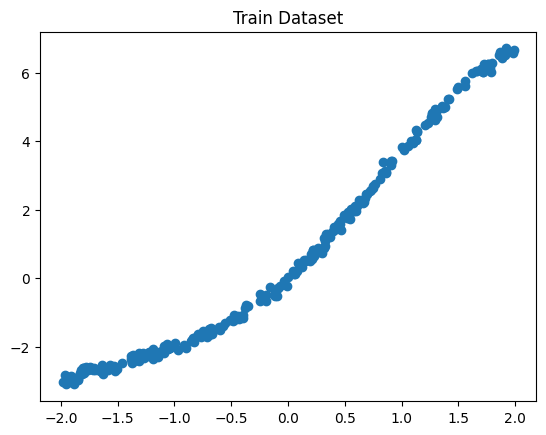

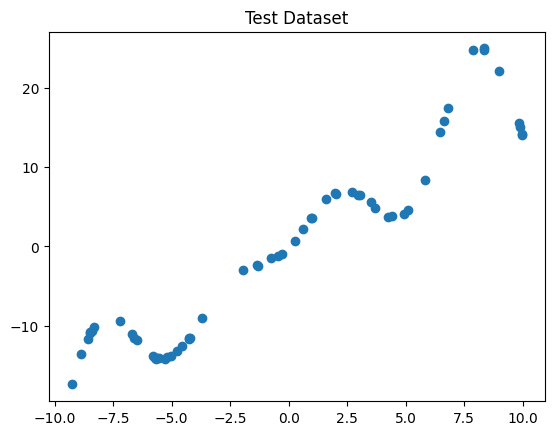

In [5]:
# Define train and test first dataset

x_train, y_train = generate_data(lambda x: 2 * x + np.sin(x) + x * np.sin(x), 240, -2, 2)
plt.scatter(x_train, y_train)
plt.title('Train Dataset')
plt.show()

# We change range_min and range_max here to test its OOD (out-of-distribution) performance

x_test, y_test = generate_data(lambda x: 2 * x + np.sin(x) + x * np.sin(x), 60, -10, 10)
plt.scatter(x_test, y_test)
plt.title('Test Dataset')
plt.show()

# EQL

Equation Learner (EQL) is a neural network-based approach to symbolic regression that discovers mathematical expressions directly from data. Unlike traditional deep learning models that treat regression as a black-box approximation, EQL is designed to output interpretable symbolic expressions. EQL uses a special type of neural network where activation functions are not just standard non-linearities (like ReLU or sigmoid) but include mathematical operations such as addition, multiplication, and trigonometric functions (e.g., sin(x), cos(x)).

<p align="center">
  <img style="margin-top: 30px" src="https://camo.githubusercontent.com/f4722b552bd6d4bd3909ff054ebef8bc4a973d9dd93e2ccacd6c77f4e03e3443/68747470733a2f2f692e696d6775722e636f6d2f485a58776656492e706e67" width="1000">
</p>

### Retrieve expressions

This cell is used to retrieve expressions from the network. Do not modify this cell.

In [6]:
# DON'T CHNAGE THIS CELL

"""
Generate a mathematical expression for the symbolic regression get_expression (also known as the EQL network) using SymPy.
This expression can be utilized for pretty-printing in various formats, including human-readable text and LaTeX.
Additionally, SymPy enables algebraic manipulation of the expression.
"""


def apply_activation(W, funcs, n_double=0):
    """Given an (n, m) matrix W and (m) vector of funcs, apply funcs to W.

    Arguments:
        W:  (n, m) matrix
        funcs: list of activation functions (SymPy functions)
        n_double:   Number of activation functions that take in 2 inputs

    Returns:
        SymPy matrix with 1 column that represents the output of applying the activation functions.
    """
    W = sp.Matrix(W)
    if n_double == 0:
        for i in range(W.shape[0]):
            for j in range(W.shape[1]):
                W[i, j] = funcs[j](W[i, j])
    else:
        W_new = W.copy()
        out_size = len(funcs)
        for i in range(W.shape[0]):
            in_j = 0
            out_j = 0
            while out_j < out_size - n_double:
                W_new[i, out_j] = funcs[out_j](W[i, in_j])
                in_j += 1
                out_j += 1
            while out_j < out_size:
                W_new[i, out_j] = funcs[out_j](W[i, in_j], W[i, in_j+1])
                in_j += 2
                out_j += 1
        for i in range(n_double):
            W_new.col_del(-1)
        W = W_new
    return W


def sym_pp(W_list, funcs, var_names, threshold=0.01, n_double=0):
    """Pretty print the hidden layers (not the last layer) of the symbolic regression network

    Arguments:
        W_list: list of weight matrices for the hidden layers
        funcs:  list of lambda functions using sympy. has the same size as W_list[i][j, :]
        var_names: list of strings for names of variables
        threshold: threshold for filtering expression. set to 0 for no filtering.
        n_double:   Number of activation functions that take in 2 inputs

    Returns:
        Simplified sympy expression.
    """
    vars = []
    for var in var_names:
        if isinstance(var, str):
            vars.append(sp.Symbol(var))
        else:
            vars.append(var)
    expr = sp.Matrix(vars).T
    # W_list = np.asarray(W_list)
    for W in W_list:
        W = filter_mat(sp.Matrix(W), threshold=threshold)
        expr = expr * W
        expr = apply_activation(expr, funcs, n_double=n_double)
    # expr = expr * W_list[-1]
    return expr


def last_pp(eq, W):
    """Pretty print the last layer."""
    return eq * filter_mat(sp.Matrix(W))


def count_inputs(funcs):
    i = 0
    for func in funcs:
        if isinstance(func, BaseFunction):
            i += 1
        elif isinstance(func, BaseFunction2):
            i += 2
    return i


def count_double(funcs):
    i = 0
    for func in funcs:
        if isinstance(func, BaseFunction2):
            i += 1
    return i


def get_expression(weights, funcs, var_names, threshold=0.01):
    """Pretty print the entire symbolic regression network.

    Arguments:
        weights: list of weight matrices for the entire network
        funcs:  list of lambda functions using sympy. has the same size as W_list[i][j, :]
        var_names: list of strings for names of variables
        threshold: threshold for filtering expression. set to 0 for no filtering.

    Returns:
        Simplified sympy expression."""
    n_double = count_double(funcs)
    funcs = [func.sp for func in funcs]

    expr = sym_pp(weights[:-1], funcs, var_names, threshold=threshold, n_double=n_double)
    expr = last_pp(expr, weights[-1])
    expr = expr[0, 0]
    return expr


def filter_mat(mat, threshold=0.01):
    """Remove elements of a matrix below a threshold."""
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            if abs(mat[i, j]) < threshold:
                mat[i, j] = 0
    return mat


def filter_expr(expr, threshold=0.01):
    expr_new = sp.Integer(0)
    for arg in expr.args:
        if arg.is_constant() and abs(arg) > threshold:   # hack way to check if it's a number
            expr_new = expr_new + arg
        elif not arg.is_constant() and abs(arg.args[0]) > threshold:
            expr_new = expr_new + arg
    return expr_new


def filter_expr2(expr, threshold=0.01):
    for a in sp.preorder_traversal(expr):
        if isinstance(a, sp.Float) and a < threshold:
            expr = expr.subs(a, 0)
    return expr

### Base Functions
These cells contain functions for use in symbolic regression. Each function encapsulates multiple implementations (SymPy, Torch) of a particular operation, allowing them to be used in different contexts. You need to complete the Torch sections.

In [7]:
# Complete TODO parts

"""Functions for use with symbolic regression.

These functions encapsulate multiple implementations (sympy, torch) of a particular function so that the
functions can be used in multiple contexts."""

class BaseFunction:
    """Abstract class for primitive functions"""
    def __init__(self, norm=1):
        self.norm = norm

    def sp(self, x):
        """Sympy implementation"""
        return None

    def torch(self, x):
        """No need for base function"""
        return None

    def name(self, x):
        return str(self.sp)


class Constant(BaseFunction):
    def torch(self, x):
        return torch.ones_like(x)

    def sp(self, x):
        return 1


class Identity(BaseFunction):
    """
    A function class that applies an identity transformation with normalization.

    Attributes:
    norm (float): A normalization factor that scales the input.

    Methods:
    torch(x: torch.Tensor) -> torch.Tensor:
        Applies the identity transformation by dividing the input by the normalization factor.
    """

    def torch(self, x: torch.Tensor) -> torch.Tensor:
        return x / self.norm
    def sp(self, x):
        return x / self.norm



class Square(BaseFunction):
    """
    A function class that applies a squared transformation with normalization.

    Methods:
    torch(x: torch.Tensor) -> torch.Tensor:
        Returns the squared value of the input, divided by the normalization factor.
    """
    def torch(self, x: torch.Tensor) -> torch.Tensor:
        return (x ** 2) / self.norm


    def sp(self, x):
        return x ** 2 / self.norm


class Pow(BaseFunction):
    """
    A function class that raises the input to a given power and normalizes the result.

    Attributes:
    power (float): The exponent to which the input is raised.

    Methods:
    torch(x: torch.Tensor) -> torch.Tensor:
        Raises the input to the specified power and divides by the normalization factor.
    """

    def __init__(self, power: float, norm: float = 1):
        """
        Initializes the Pow function with a given exponent and normalization factor.

        Parameters:
        power (float): The exponent for the power function.
        norm (float, optional): The normalization factor. Default is 1.
        """

        BaseFunction.__init__(self, norm=norm)
        self.power = power

    def torch(self, x: torch.Tensor) -> torch.Tensor:
        return x ** self.power / self.norm


    def sp(self, x):
        return x ** self.power / self.norm

class Sin(BaseFunction):
    """
    A function class that applies a sine transformation with frequency scaling and normalization.

    Methods:
    torch(x: torch.Tensor) -> torch.Tensor:
        Applies a sine transformation to the input and divides by the normalization factor.
    """

    def torch(self, x: torch.Tensor) -> torch.Tensor:
        return torch.sin(x * 2*2 * np.pi) / self.norm  # 2*2*np.pi

    def sp(self, x):
        return sp.sin(x * 2*2*np.pi) / self.norm


class Sigmoid(BaseFunction):
    """
    A function class that applies the sigmoid function with normalization.

    Methods:
    torch(x: torch.Tensor) -> torch.Tensor:
        Applies the sigmoid function and divides by the normalization factor.
    """

    def torch(self, x: torch.Tensor) -> torch.Tensor:
        return (1 / (1 + torch.exp(-20 * x))) / self.norm


    def sp(self, x):
        return 1 / (1 + sp.exp(-20*x)) / self.norm

    def name(self, x):
        return "sigmoid(x)"


class Exp(BaseFunction):
    """
    A function class that applies an exponential transformation with normalization.

    Methods:
    torch(x: torch.Tensor) -> torch.Tensor:
        Applies the exponential function (subtracting 1) and divides by the normalization factor.
    """

    def __init__(self, norm: float = np.e):
        """
        Initializes the Exp function with a normalization factor.

        Parameters:
        norm (float, optional): The normalization factor. Default is Euler's number (e).
        """
        super().__init__(norm)

    def torch(self, x: torch.Tensor) -> torch.Tensor:
        return (torch.exp(x) - 1) / self.norm

    def sp(self, x):
        return (sp.exp(x) - 1) / self.norm


class Log(BaseFunction):
    """
    A function class that applies the logarithm function with normalization.

    Methods:
    torch(x: torch.Tensor) -> torch.Tensor:
        Applies the logarithm function (on the absolute value of input) and divides by the normalization factor.
    """

    def torch(self, x: torch.Tensor) -> torch.Tensor:
        return torch.log(torch.abs(x)) / self.norm

    def sp(self, x):
        return sp.log(sp.Abs(x)) / self.norm


class BaseFunction2:
    """Abstract class for primitive functions with 2 inputs"""
    def __init__(self, norm=1.):
        self.norm = norm

    def sp(self, x, y):
        """Sympy implementation"""
        return None

    def torch(self, x, y):
        return None

    def name(self, x, y):
        return str(self.sp)


class Product(BaseFunction2):
    """
    A function class that computes the product of two inputs with normalization.

    Methods:
    torch(x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        Computes the product of two input tensors and divides by the normalization factor.
    """

    def __init__(self, norm: float = 0.1):
        """
        Initializes the Product function with a normalization factor.

        Parameters:
        norm (float, optional): The normalization factor. Default is 0.1.
        """
        super().__init__(norm=norm)

    def torch(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        return (x * y) / self.norm

    def sp(self, x, y):
        return x * y / self.norm



### Model Architecture

In this section, we define the architecture of the symbolic regression neural network using the Equation Learner (EQL) approach. The model is designed to learn mathematical expressions by incorporating activation functions that correspond to primitive mathematical operations.

1. SymbolicLayer: Each layer applies a set of predefined functions (e.g., sin(x), cos(x), x^2, etc.). The weight matrix determines how input features are transformed and combined. Functions are applied either as single-input (f(x)) or double-input (f(x, y)) operations.

2. SymbolicNet: Composed of multiple SymbolicLayer instances. Uses trainable weight matrices to learn meaningful expressions. The final layer outputs a weighted sum without an activation function.

In [16]:
class SymbolicLayer(nn.Module):
    def __init__(self, funcs, initial_weight=None, init_stddev=0.1, in_dim=None):
        super().__init__()

        self.output = None
        self.n_funcs = len(funcs)
        self.funcs = [func.torch for func in funcs]
        self.n_double = count_double(funcs)
        self.n_single = self.n_funcs - self.n_double
        self.out_dim = self.n_funcs + self.n_double
        self.initial_weight = initial_weight

        if initial_weight is not None:
            self.W = nn.Parameter(torch.tensor(initial_weight, dtype=torch.float32))
        else:
            assert in_dim is not None
            self.W = nn.Parameter(torch.randn(in_dim, self.out_dim) * init_stddev)

    def forward(self, x):
        g = x @ self.W
        out = self._compute_outputs(g)
        self.output = torch.stack(out, dim=1)
        return self.output

    def _compute_outputs(self, g):
        out = []
        in_j = 0
        out_j = 0

        in_j, out_j = self._apply_single_input_funcs(g, out, in_j, out_j)
        self._apply_double_input_funcs(g, out, in_j, out_j)

        return out

    def _apply_single_input_funcs(self, g, out, in_j, out_j):
        while out_j < self.n_single:
            out.append(self.funcs[out_j](g[:, in_j]))
            in_j += 1
            out_j += 1
        return in_j, out_j

    def _apply_double_input_funcs(self, g, out, in_j, out_j):
        while out_j < self.n_funcs:
            out.append(self.funcs[out_j](g[:, in_j], g[:, in_j + 1]))
            in_j += 2
            out_j += 1

    def get_weight(self):
        return self.W.cpu().detach().numpy()

    def get_weight_tensor(self):
        return self.W.clone()


class SymbolicNet(nn.Module):
    def __init__(self, symbolic_depth, in_dim=1, funcs=None, initial_weights=None, init_stddev=0.1):
        super(SymbolicNet, self).__init__()

        self.depth = symbolic_depth
        self.hidden_layers = self._build_hidden_layers(symbolic_depth, in_dim, funcs, initial_weights, init_stddev)
        self.output_weight = self._init_output_weight(initial_weights, init_stddev, self.hidden_layers[-1].n_funcs)

    def _build_hidden_layers(self, depth, in_dim, funcs, initial_weights, init_stddev):
        layers = []
        input_dim = in_dim

        for i in range(depth):
            init_weight = None if initial_weights is None else initial_weights[i]
            std = init_stddev if not isinstance(init_stddev, list) else init_stddev[i]

            layer = SymbolicLayer(funcs, initial_weight=init_weight, init_stddev=std, in_dim=input_dim)
            layers.append(layer)
            input_dim = layer.n_funcs

        return nn.Sequential(*layers)

    def _init_output_weight(self, initial_weights, init_stddev, input_dim):
        if initial_weights is not None:
            final_weight = initial_weights[-1]
            return nn.Parameter(torch.tensor(final_weight, dtype=torch.float32))
        else:
            return nn.Parameter(torch.randn(input_dim, 1) * init_stddev)

    def forward(self, input):
        out = input
        for layer in self.hidden_layers:
            out = layer(out)
        return out @ self.output_weight

    def get_weights(self):
        return [self.hidden_layers[i].get_weight() for i in range(self.depth)] + \
               [self.output_weight.cpu().detach().numpy()]

    def get_weights_tensor(self):
        return [self.hidden_layers[i].get_weight_tensor() for i in range(self.depth)] + \
               [self.output_weight.clone()]

### Training phase

In [10]:
def train(
    x_train,
    y_train,
    activation_funcs,
    in_dim,
    n_layers,
    learning_rate,
    summary_step,
    epochs,
    device="cuda"
):
    x_train, y_train = x_train.to(device), y_train.to(device)

    net = SymbolicNet(
        symbolic_depth=n_layers,
        in_dim=in_dim,
        funcs=activation_funcs,
        initial_weights=None,
        init_stddev=0.1
    ).to(device)

    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        net.train()
        outputs = net(x_train)
        loss = F.mse_loss(outputs, y_train)
        if torch.isnan(loss):
            print("NaN loss: Restarting Training")
            return train(x_train, y_train, activation_funcs, in_dim, n_layers, learning_rate, summary_step, epochs, device)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (epoch + 1) % summary_step == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}")
    return net


def test(net, x_test, y_test, device="cuda"):
    """
    This function tests a symbolic regression network using the provided test data.

    Parameters:
    - net: The trained symbolic regression network (instance of SymbolicNet).
    - x_test: Tensor, the input test data.
    - y_test: Tensor, the target test data.
    - device: String, the device where the test will occur (default is "cuda" for GPU).

    Returns:
    - test_loss: test loss value.
    """

    x_test, y_test = x_test.to(device), y_test.to(device)
    with torch.no_grad():  # test error
        test_outputs = net(x_test)
        test_loss = F.mse_loss(test_outputs, y_test)

    if np.isnan(test_loss.item()):
        return float('inf')
    return test_loss.item()




In [11]:
# Don't change this cell

# Define the function that evaluates the expression
def symbolic_function(expr_str, x):
    return eval(expr_str, {"x_1": x, "x1": x, "np": np, "sin": np.sin, "cos": np.cos, "exp": np.exp})

# Function to plot the symbolic regression output and test dataset
def plot_symbolic(x_test, y_test, expr_str):
    x_values = np.linspace(-10, 10, 50)
    y_values = np.array([symbolic_function(expr_str, x) for x in x_values])

    plt.figure(figsize=(10, 5))
    plt.plot(x_values, y_values, label="Symbolic Regression Output", color='b')
    plt.scatter(x_test, y_test, label="Test Dataset", color='r', s=5)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Best results of Symbolic Regression")
    plt.legend()
    plt.grid(True)
    plt.show()

In [12]:
def find_expression(net, x_dim):
  with torch.no_grad():
      weights = net.get_weights()
      expr_str = get_expression(weights, activation_funcs, var_names[:x_dim])
      return expr_str


def run(x_train, x_test, y_train, y_test, activation_funcs, n_layers, learning_rate, summary_step, epochs, trials=10):
    test_losses = []
    expressions = []

    for trial in range(trials):
        print(f"Trial {trial+1}/{trials} ------------------------")

        net = train(
            x_train=x_train,
            y_train=y_train,
            activation_funcs=activation_funcs,
            in_dim=x_train.shape[1],
            n_layers=n_layers,
            learning_rate=learning_rate,
            summary_step=summary_step,
            epochs=epochs,
            device="cuda" if torch.cuda.is_available() else "cpu"
        )

        loss = test(net, x_test, y_test)
        expr = find_expression(net, x_train.shape[1])
        print(f"Test Loss: {loss:.6f}")
        print(f"Expression: {expr}\n")
        test_losses.append(loss)
        expressions.append(expr)

    best_index = np.argmin(np.array(test_losses))
    return str(expressions[best_index])





Trial 1/10 ------------------------
Epoch [100/1000], Loss: 0.011233
Epoch [200/1000], Loss: 0.009677
Epoch [300/1000], Loss: 0.009270
Epoch [400/1000], Loss: 0.009107
Epoch [500/1000], Loss: 0.009055
Epoch [600/1000], Loss: 0.009030
Epoch [700/1000], Loss: 0.009012
Epoch [800/1000], Loss: 0.008997
Epoch [900/1000], Loss: 0.008985
Epoch [1000/1000], Loss: 0.008976
Test Loss: 1311.087402
Expression: -0.00323828220668174*x_1**2 + 0.141294*x_1 - 2.84258365631104*(0.077862817869796*x_1**2 + 0.0520981*x_1 - 0.0798799*sin(1.10390056803818*x_1) + 0.591254 + 0.0843755/(exp(0.815091*x_1) + 1) + 0.254448/(1 + exp(-3.03969*x_1)))*(-0.00939745988142494*x_1**2 - 0.20555*x_1 - 0.0314299154805087*exp(0.0296912*x_1) - 0.204987*sin(0.502643718568443*x_1) - 0.242461*sin(1.10390056803818*x_1) + 0.141037887685194 + 0.172748/(exp(0.815091*x_1) + 1) - 0.252763/(1 + exp(-3.03969*x_1))) + 1.37315437197685*(-0.0591020967359896*x_1**2 - 0.101838*x_1 - 0.210363*sin(0.502643718568443*x_1) - 0.240677*sin(1.1039005

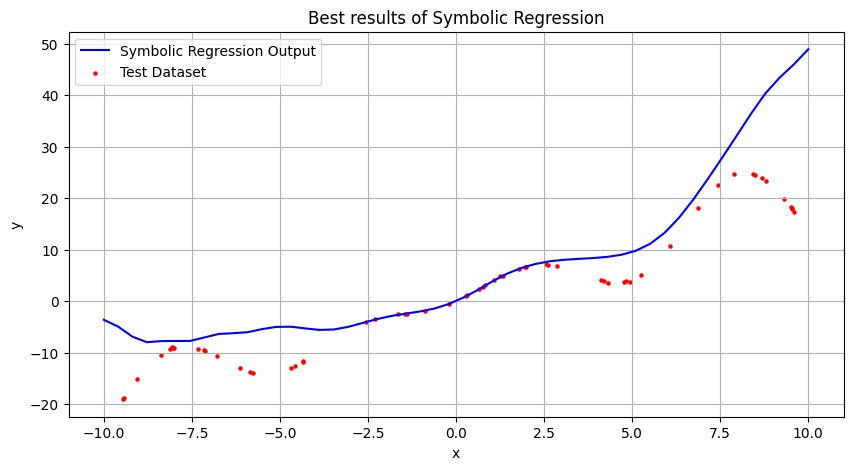

In [ ]:
activation_funcs = [
    *[Constant()] * 2,
    *[Identity()] * 4,
    *[Square()] * 4,
    *[Sin()] * 2,
    *[Exp()] * 2,
    *[Sigmoid()] * 2,
    *[Product()] * 2,
]


var_names = ["x_1", "x_2"]      # This is the name of vars to show at the end.


n_layers = 2                  # Try 2-3 to start
reg_weight = 0.001           # Optional: if you add L1/L2 regularization
learning_rate = 0.01        # Start small (e.g., 0.001–0.01)
summary_step = 100           # Log every 100 epochs
epochs = 1000                # Enough for convergence
trials = 10                  # Minimum 5, 10 is good for robustness

best_expr = run(x_train, x_test, y_train, y_test, activation_funcs, n_layers, learning_rate, summary_step, epochs, trials)
plot_symbolic(x_test, y_test, best_expr.replace("exp", "np.exp").replace("sin", "np.sin"))


Trial 1/10 ------------------------
Epoch [100/1000], Loss: 0.009331
Epoch [200/1000], Loss: 0.009180
Epoch [300/1000], Loss: 0.009143
Epoch [400/1000], Loss: 0.017763
Epoch [500/1000], Loss: 0.008988
Epoch [600/1000], Loss: 0.018827
Epoch [700/1000], Loss: 0.008882
Epoch [800/1000], Loss: 0.008822
Epoch [900/1000], Loss: 0.008802
Epoch [1000/1000], Loss: 0.010572
Test Loss: inf
Expression: 0.076104637328028*x_1**2 + 0.0233828*x_1 - 0.00556712587974078*(-0.130856681831089*x_1**2 + 0.0862479031522685*x_1 - 0.126034279301709*exp(0.127643*x_1) - 0.407203732346216*sin(0.3322681126663*x_1) - 1 + 0.154338231928865*exp(-0.0305556*x_1) - 0.826400932530459/(exp(2.72537*x_1) + 1) - 0.343226428045688/(exp(1.84658*x_1) + 1))**2 - 0.913628874857062*(0.00256206563221407*x_1**2 - 0.014605*x_1 + 0.00828394475360917*exp(0.127643*x_1) - 0.121579*sin(0.3322681126663*x_1) - 0.217777*sin(0.769241696130022*x_1) + 0.118147490592994 + 0.0793687/(exp(2.72537*x_1) + 1) + 0.0413057/(exp(1.84658*x_1) + 1))*(0.049

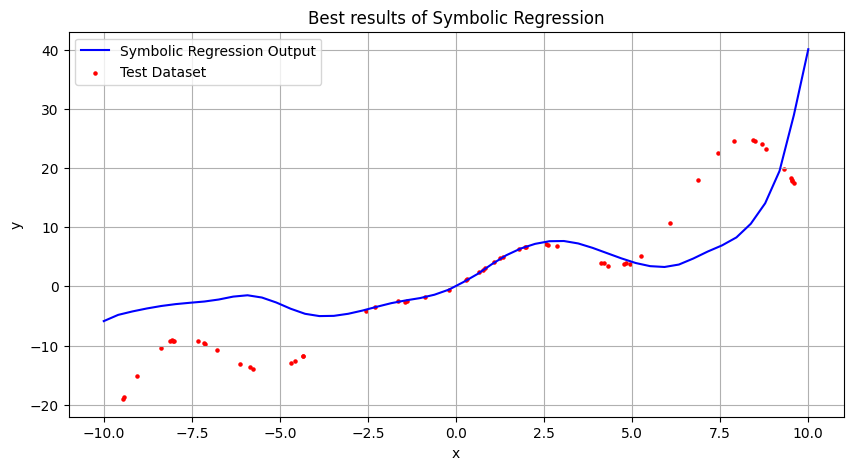

Trial 1/10 ------------------------
Epoch [100/1000], Loss: 0.009188
Epoch [200/1000], Loss: 0.008874
Epoch [300/1000], Loss: 0.008831
Epoch [400/1000], Loss: 0.010950
Epoch [500/1000], Loss: 0.008806
Epoch [600/1000], Loss: 0.008767
Epoch [700/1000], Loss: 0.008681
Epoch [800/1000], Loss: 0.008577
Epoch [900/1000], Loss: 0.008627
Epoch [1000/1000], Loss: 0.008462
Test Loss: 77125621087469568.000000
Expression: 0.00760116184981438*x_1**2 + 0.026058*x_1 + 0.769129553645442*(-0.0242266406511362*x_1**2 + 0.00942771*x_1 - 0.00805382503192612*exp(0.145551*x_1) + 0.0505445*sin(0.613622462970034*x_1) + 0.0401609*sin(0.66075613864253*x_1) - 0.0368142269738417 - 0.0368619/(exp(0.658211*x_1) + 1) - 0.197655/(1 + exp(-1.73277*x_1)))*(-0.0223980621543484*x_1**2 - 0.0139699*x_1 - 0.0372241284644536*exp(0.145551*x_1) + 0.0243993*sin(0.613622462970034*x_1) + 0.0344387*sin(0.66075613864253*x_1) - 0.173877077506343 + 0.0121968406696649*exp(-0.0223793*x_1) + 0.127744/(exp(0.658211*x_1) + 1) - 0.0348923/

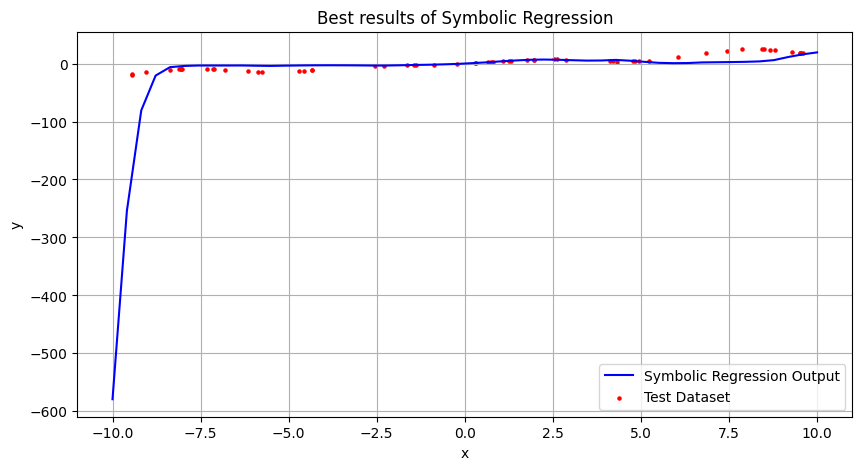

In [ ]:
# Now, change the activation functions and the number of layers (n_layers) to observe the effect on the outputs.

for n_layers in range(3, 5):
    best_expr = run(x_train, x_test, y_train, y_test, activation_funcs, n_layers, learning_rate, summary_step, epochs, trials)
    plot_symbolic(x_test, y_test, best_expr.replace("exp", "np.exp").replace("sin", "np.sin"))


We were previously working with the first dataset. Now, evaluate the model on the second dataset and extract the corresponding expression.

In [ ]:
import torch
import pandas as pd
from sklearn.model_selection import train_test_split

def load_dataset(path):
    """Load dataset from CSV and split into X and y tensors."""
    df = pd.read_csv(path)
    y = torch.tensor(df.iloc[:, 0].values.reshape(-1, 1), dtype=torch.float32)
    x = torch.tensor(df.iloc[:, 1:].values, dtype=torch.float32)
    return x, y

def split_data(x, y, test_size=0.2, random_state=42):
    """Split dataset into training and test sets."""
    return train_test_split(x, y, test_size=test_size, random_state=random_state)

def get_hyperparameters():
    """Define training hyperparameters."""
    return {
        "n_layers": 2,
        "reg_weight": 0.001,
        "learning_rate": 0.001,
        "summary_step": 100,
        "epochs": 1000,
        "trials": 10
    }

def train_and_report(x_train, x_test, y_train, y_test, activation_funcs, hparams):
    """Run the training process and print best expression."""
    best_expr = run(
        x_train, x_test, y_train, y_test,
        activation_funcs, hparams["n_layers"],
        hparams["learning_rate"], hparams["summary_step"],
        hparams["epochs"], hparams["trials"]
    )
    print("Best expression for second dataset:")
    print(best_expr)
    return best_expr


# ====================== Execution ======================

x_data2, y_data2 = load_dataset("./dataset.csv")
print(x_data2, y_data2)

x_train2, x_test2, y_train2, y_test2 = split_data(x_data2, y_data2)
hparams = get_hyperparameters()

best_expr2 = train_and_report(
    x_train2, x_test2, y_train2, y_test2, activation_funcs, hparams
)

tensor([[1.3699, 0.4628],
        [3.0002, 0.2661],
        [3.0155, 0.3226],
        [2.6579, 0.2125],
        [2.9917, 0.3883],
        [0.6867, 0.2707],
        [3.7835, 1.3355],
        [3.3716, 1.7340],
        [1.9830, 0.4211],
        [0.2072, 1.1119],
        [1.7634, 0.3723],
        [3.2498, 0.2701],
        [1.4746, 1.2475],
        [1.0683, 4.3736],
        [0.5298, 0.7747],
        [4.2065, 0.9311],
        [1.3856, 0.3021],
        [2.4827, 0.3670],
        [1.8081, 0.2596],
        [4.6619, 0.8117],
        [0.1086, 0.6902],
        [0.6682, 0.9864],
        [4.7355, 1.1239],
        [4.9977, 0.3704],
        [3.8438, 1.8583],
        [3.1993, 0.2468],
        [0.1562, 0.3531],
        [2.8446, 0.6346],
        [4.4711, 1.1929],
        [1.4848, 0.2424],
        [2.0862, 0.4912],
        [3.2854, 1.5342],
        [3.9906, 0.2489],
        [2.7358, 0.3151],
        [2.4403, 0.2022],
        [4.1447, 0.2233],
        [3.2218, 0.7747],
        [3.4737, 1.7930],
        [0.6

### Bonus

We know that in the first and second dataset, the expression is simple and contains only one or at most two terms. However, as you can see, the expressions here are quite long. Now, think about what adjustments you can make to simplify them and reduce their length.

Epoch Number: [200/5000] Loss: 0.039911
Epoch Number: [400/5000] Loss: 0.030642
Epoch Number: [600/5000] Loss: 0.025613
Epoch Number: [800/5000] Loss: 0.022131
Epoch Number: [1000/5000] Loss: 0.019988
Epoch Number: [1200/5000] Loss: 0.018163
Epoch Number: [1400/5000] Loss: 0.016952
Epoch Number: [1600/5000] Loss: 0.016157
Epoch Number: [1800/5000] Loss: 0.015952
Epoch Number: [2000/5000] Loss: 0.015087
Epoch Number: [2200/5000] Loss: 0.014628
Epoch Number: [2400/5000] Loss: 0.018107
Epoch Number: [2600/5000] Loss: 0.014235
Epoch Number: [2800/5000] Loss: 0.014226
Epoch Number: [3000/5000] Loss: 0.014795
Epoch Number: [3200/5000] Loss: 0.014309
Epoch Number: [3400/5000] Loss: 0.013872
Epoch Number: [3600/5000] Loss: 0.014595
Epoch Number: [3800/5000] Loss: 0.013716
Epoch Number: [4000/5000] Loss: 0.014425
Epoch Number: [4200/5000] Loss: 0.015136
Epoch Number: [4400/5000] Loss: 0.013645
Epoch Number: [4600/5000] Loss: 0.013608
Epoch Number: [4800/5000] Loss: 0.013643
Epoch Number: [5000/

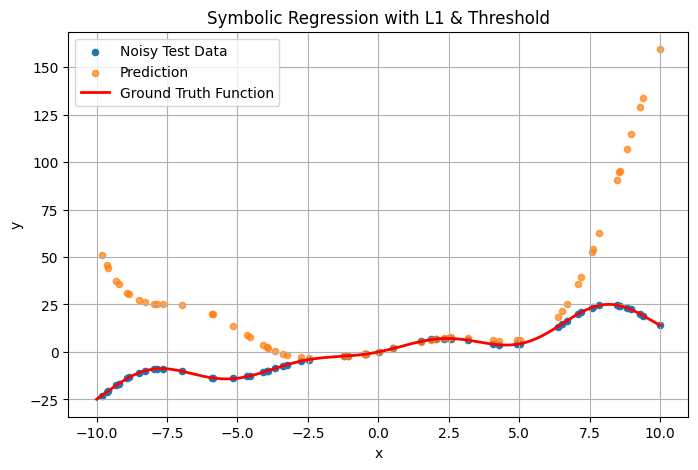

In [18]:
def train(
        x_train,
        y_train,
        funcs,
        in_dim,
        depth,
        lr,
        summary_step,
        epochs,
        reg_weight, 
        device="cpu"
    ):
    x_train, y_train = x_train.to(device), y_train.to(device)
    net = SymbolicNet(depth, in_dim, funcs).to(device)
    opt = optim.Adam(net.parameters(), lr=lr)
    for epoch in range(1, epochs+1):
        opt.zero_grad()
        pred = net(x_train)
        l1   = sum(p.abs().sum() for p in net.parameters())
        loss = F.mse_loss(pred, y_train) + reg_weight * l1
        loss.backward()
        opt.step()
        if epoch % summary_step == 0:
            print(f"Epoch Number: [{epoch}/{epochs}] Loss: {loss.item():.6f}")
    return net

def find_expression(net, x_dim, threshold):
    return str(get_expression(net.get_weights(), activation_funcs,
                              var_names[:x_dim], threshold))

def generate_data(func, N, rmin, rmax, noise):
    x_dim = len(signature(func).parameters)
    x = (rmax - rmin) * torch.rand(N, x_dim) + rmin
    y = torch.tensor([[func(*xi)] for xi in x], dtype=torch.float32)
    y += torch.randn_like(y) * noise
    return x, y

var_names = ["x_1"]
depth = 2
lr  = 0.01
summary_step  = 200
epochs = 5000
reg_weight = 0.001
threshold = 0.10
device  = "cpu"

x_train, y_train = generate_data(lambda x: 2*x + np.sin(x) + x*np.sin(x), 240, -2, 2, 0.1)
x_test,  y_test  = generate_data(lambda x: 2*x + np.sin(x) + x*np.sin(x),  60, -10,10,0.1)

activation_funcs = [*([Constant()]*2), *([Identity()]*4), *([Square()]*4), *([Sin()]*2),  *([Exp()]*2), *([Sigmoid()]*2), *([Product()]*2)]

net = train(x_train, y_train, activation_funcs,
            x_train.shape[1], depth,
            lr, summary_step, epochs,
            reg_weight, device)

expr = find_expression(net, x_train.shape[1], threshold)
print("\nRecovered Expression:", expr)

x_vals = x_test.numpy().flatten()
y_true = y_test.numpy().flatten()

pred_y = net(x_test.to(device)).detach().cpu().numpy().flatten()

x_line = np.linspace(-10,10,300)
y_line = 2*x_line + np.sin(x_line) + x_line*np.sin(x_line)

plt.figure(figsize=(8,5))
plt.scatter(x_vals, y_true, label="Noisy Test Data", s=20)
plt.scatter(x_vals, pred_y, label="Prediction", s=20, alpha=0.7)
plt.plot(x_line, y_line, label="Ground Truth Function", color='red', linewidth=2)
plt.xlabel("x"); plt.ylabel("y")
plt.title("Symbolic Regression with L1 & Threshold")
plt.legend(); plt.grid(True)
plt.show()

# Seq2Seq-Based Symbolic Regression with Transformers

<p align="center">
  <img style="margin-top: 30px" src="https://cdn.botpenguin.com/assets/website/Sequence_to_Sequence_Models_0b5fb158a1.webp" width="500">
</p>

Symbolic regression is a method that aims to find a mathematical expression that best fits a given dataset. Unlike traditional regression techniques, symbolic regression does not assume a predefined function structure; instead, it searches for an optimal mathematical expression that relates input features to target variables. One effective approach to symbolic regression is using sequence-to-sequence (Seq2Seq) models based on transformers.

### Overview of Seq2Seq Models in Symbolic Regression:
A Seq2Seq model consists of an encoder and a decoder, both of which are typically built using transformer architectures. The main idea is to treat symbolic regression as a sequence translation problem, where:
- The input is a set of numerical data points (features).
- The output is a mathematical expression represented as a sequence of tokens.
- This approach allows the model to learn a mapping from numerical inputs to symbolic expressions, making it a powerful tool for symbolic regression.

### Encoder: Processing the Input Data

The encoder in a Seq2Seq transformer is responsible for encoding the full dataset into a latent representation. Here’s how it works:

1. Tokenization: The input dataset (typically a set of feature-value pairs) is transformed into a sequence of tokens. Each token can represent a numerical value or a special marker that indicates structural information.

2. Embedding Layer: The numerical tokens are converted into dense vector representations using an embedding layer.

3. Positional Encoding: Since transformers do not have built-in recurrence mechanisms, positional encodings are added to the embeddings to retain the order of the input sequence.

4. Self-Attention Mechanism: The encoder consists of multiple self-attention layers that allow the model to weigh the importance of different parts of the input sequence dynamically.

5. Output Representation: The encoder outputs a context-aware representation of the input sequence, which is then passed to the decoder.

### Decoder: Generating the Mathematical Expression
The decoder takes the encoder’s output and generates the target sequence, which is a symbolic mathematical expression. This process follows these steps:

1. Input Token Embedding: The decoder receives an initial input token (typically a start-of-sequence token <SOS>).

2. Self-Attention Layers: The decoder generates tokens one by one, attending to previously generated tokens using masked self-attention.

3. Cross-Attention with Encoder Outputs: The decoder also attends to the encoder’s output using cross-attention layers, ensuring that the generated expression is conditioned on the input data.

4. Token Generation via Softmax: The final layer applies a softmax function over the vocabulary (consisting of mathematical symbols, operators, and variables) to predict the next token.


In this section, we will implement symbolic regression using transformers. First, we generate the dataset and save it in the `data` folder. Do not modify the cell below. We suggest reading and understanding it first.

In [2]:
# Don't change this cell.

C, x1, x2, x3, x4, x5, x6 = sympy.symbols('C, x1, x2, x3, x4, x5, x6', real=True, positive=True)

MY_VOCAB = np.array([
    ['add', 4, 2],  # binary operators
    ['sub', 3, 2],
    ['mul', 6, 2],
    ['sin', 1, 1],  # unary operators
    ['cos', 1, 1],
    ['log', 2, 1],
    ['exp', 2, 1],
    ['neg', 0, 1],
    ['inv', 3, 1],
    ['sq', 2, 1],
    ['cb', 0, 1],
    ['sqrt', 2, 1],
    ['cbrt', 0, 1],
    ['C', 8, 0],  # leaves
    ['x1', 8, 0],
    ['x2', 8, 0],
    ['x3', 4, 0],
    ['x4', 4, 0],
    ['x5', 2, 0],
    ['x6', 2, 0],
])


def generate_expression(vocab):
    """
    Recursive function!
    Generate one expression using the tokens and their
    respective probabiities provided by 'vocab'.
    """
    weights = vocab[:, 1].astype('float32')
    probs = weights / np.sum(weights)
    N = len(vocab)
    expr = []
    rand_idx = np.random.choice(N, p=probs)
    cur_token = vocab[rand_idx, 0]
    cur_arity = int(vocab[rand_idx, 2])
    expr.append(cur_token)
    if cur_arity==0:
        return expr
    else:
        if cur_token in ['sin', 'cos']:
            idx1 = np.where(vocab[:, 0]=='sin')[0][0]
            idx2 = np.where(vocab[:, 0]=='cos')[0][0]
            new_vocab = np.delete(vocab, [idx1, idx2], axis=0)
        elif cur_token in ['log', 'exp']:
            idx1 = np.where(vocab[:, 0]=='log')[0][0]
            idx2 = np.where(vocab[:, 0]=='exp')[0][0]
            new_vocab = np.delete(vocab, [idx1, idx2], axis=0)
        else:
            new_vocab = vocab
        if cur_arity==1:
            child = generate_expression(new_vocab)
            return expr + child
        elif cur_arity==2:
            child1 = generate_expression(new_vocab)
            child2 = generate_expression(new_vocab)
            return expr + child1 + child2


def translate_integers_into_tokens(seq_int):
    seq_tokens = []
    for n in range(len(seq_int)):
        if seq_int[n]>=2:
            seq_tokens.append(MY_VOCAB[seq_int[n]-2])
    return seq_tokens


def from_sequence_to_sympy(expr):
    """
    Recursive function!
    Convert the initial sequence of tokens into SymPy expression.
    """


    MY_VOCAB = np.array([
        ['add', 4, 2],  # binary operators
        ['sub', 3, 2],
        ['mul', 6, 2],
        ['sin', 1, 1],  # unary operators
        ['cos', 1, 1],
        ['log', 2, 1],
        ['exp', 2, 1],
        ['neg', 0, 1],
        ['inv', 3, 1],
        ['sq', 2, 1],
        ['cb', 0, 1],
        ['sqrt', 2, 1],
        ['cbrt', 0, 1],
        ['C', 8, 0],  # leaves
        ['x1', 8, 0],
        ['x2', 8, 0],
        ['x3', 4, 0],
        ['x4', 4, 0],
        ['x5', 2, 0],
        ['x6', 2, 0],
    ])


    cur_token = expr[0]
    try:
        return float(cur_token)  # for cases when constants are evaluated
    except ValueError:
        cur_idx = np.where(MY_VOCAB[:, 0]==cur_token)[0][0]
        cur_arity = int(MY_VOCAB[cur_idx, 2])
    if cur_arity==0:
        if cur_token=='C':
            return C
        elif cur_token=='x1':
            return x1
        elif cur_token=='x2':
            return x2
        elif cur_token=='x3':
            return x3
        elif cur_token=='x4':
            return x4
        elif cur_token=='x5':
            return x5
        elif cur_token=='x6':
            return x6
    elif cur_arity==1:
        if cur_token=='sin':
            return sympy.sin(from_sequence_to_sympy(expr[1:]))
        elif cur_token=='cos':
            return sympy.cos(from_sequence_to_sympy(expr[1:]))
        elif cur_token=='log':
            return sympy.log(from_sequence_to_sympy(expr[1:]))
        elif cur_token=='exp':
            return sympy.exp(from_sequence_to_sympy(expr[1:]))
        elif cur_token=='neg':
            return - from_sequence_to_sympy(expr[1:])
        elif cur_token=='inv':
            return 1 / from_sequence_to_sympy(expr[1:])
        elif cur_token=='sq':
            return (from_sequence_to_sympy(expr[1:]))**2
        elif cur_token=='cb':
            return (from_sequence_to_sympy(expr[1:]))**3
        elif cur_token=='sqrt':
            return sympy.sqrt(from_sequence_to_sympy(expr[1:]))
        elif cur_token=='cbrt':
            return sympy.cbrt(from_sequence_to_sympy(expr[1:]))
    elif cur_arity==2:
        arity_count = 1
        idx_split = 1
        for temp_token in expr[1:]:
            try:
                float(temp_token)  # for cases when constants are evaluated
                arity_count += -1
            except ValueError:
                temp_idx = np.where(MY_VOCAB[:, 0]==temp_token)[0][0]
                arity_count += int(MY_VOCAB[temp_idx, 2]) - 1
            idx_split += 1
            if arity_count==0:
                break
        left_list = expr[1:idx_split]
        right_list = expr[idx_split:]
        if cur_token=='add':
            return from_sequence_to_sympy(left_list) + from_sequence_to_sympy(right_list)
        elif cur_token=='sub':
            return from_sequence_to_sympy(left_list) - from_sequence_to_sympy(right_list)
        elif cur_token=='mul':
            return from_sequence_to_sympy(left_list) * from_sequence_to_sympy(right_list)


def from_sequence_to_string(expr):
    """
    OBSOLETE
    Recursive function!
    Convert the initial sequence of tokens into a string
    which can be read by SymPy.
    """


    MY_VOCAB = np.array([
        ['add', 4, 2],  # binary operators
        ['sub', 3, 2],
        ['mul', 6, 2],
        ['sin', 1, 1],  # unary operators
        ['cos', 1, 1],
        ['log', 2, 1],
        ['exp', 2, 1],
        ['neg', 0, 1],
        ['inv', 3, 1],
        ['sq', 2, 1],
        ['cb', 0, 1],
        ['sqrt', 2, 1],
        ['cbrt', 0, 1],
        ['C', 8, 0],  # leaves
        ['x1', 8, 0],
        ['x2', 8, 0],
        ['x3', 4, 0],
        ['x4', 4, 0],
        ['x5', 2, 0],
        ['x6', 2, 0],
    ])

    cur_token = expr[0]
    try:
        float(cur_token)  # for cases when constants are evaluated
        cur_arity = 0
    except ValueError:
        cur_idx = np.where(MY_VOCAB[:, 0]==cur_token)[0][0]
        cur_arity = int(MY_VOCAB[cur_idx, 2])
    if cur_arity==0:
        return cur_token
    elif cur_arity==1:
        if cur_token=='inv':
            return '1/(' + from_sequence_to_string(expr[1:]) + ')'
        elif cur_token=='sq':
            return '(' + from_sequence_to_string(expr[1:]) + ')**2'
        elif cur_token=='cb':
            return '(' + from_sequence_to_string(expr[1:]) + ')**3'
        elif cur_token=='neg':
            return '-(' + from_sequence_to_string(expr[1:]) + ')'
        else:
            return cur_token + '(' + from_sequence_to_string(expr[1:]) + ')'
    elif cur_arity==2:
        arity_count = 1
        idx_split = 1
        for temp_token in expr[1:]:
            try:
                float(temp_token)  # for cases when constants are evaluated
                arity_count += -1
            except ValueError:
                temp_idx = np.where(MY_VOCAB[:, 0]==temp_token)[0][0]
                arity_count += int(MY_VOCAB[temp_idx, 2]) - 1
            idx_split += 1
            if arity_count==0:
                break
        left_list = expr[1:idx_split]
        right_list = expr[idx_split:]
        if cur_token=='add':
            return '(' + from_sequence_to_string(left_list) + ')+(' + from_sequence_to_string(right_list) + ')'
        elif cur_token=='sub':
            return '(' + from_sequence_to_string(left_list) + ')-(' + from_sequence_to_string(right_list) + ')'
        elif cur_token=='mul':
            return '(' + from_sequence_to_string(left_list) + ')*(' + from_sequence_to_string(right_list) + ')'


def expression_tree_depth(sympy_expr):
    """
    Recursive function!
    Count the maximum depth for a given SymPy expression.
    """
    if len(sympy_expr.args)==0:
        return 1
    elif len(sympy_expr.args)==1:
        return 1 + expression_tree_depth(sympy_expr.args[0])
    else:
        max_depth = 0
        for a in sympy_expr.args:
            temp_depth = expression_tree_depth(a)
            if temp_depth > max_depth:
                max_depth = temp_depth
        return 1 + max_depth


def first_variables_first(sympy_expr):
    """
    Counts the number of variables in the SymPy expression,
    and assign firte variables first.
    Example: log(x3)+x5 becomes log(x1)+x2
    """
    tokens = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6']
    sympy_str = str(sympy_expr)
    exist = []
    for t in tokens:
        exist.append(t in sympy_str)
    for idx_new, idx_old in enumerate(np.where(exist)[0]):
        sympy_str = sympy_str.replace(f'x{idx_old+1}', f'x{idx_new+1}')
    sympy_expr = sympy.sympify(sympy_str)
    return sympy_expr


def from_sympy_to_sequence(sympy_expr):
    """
    Recursive function!
    Convert a SymPy expression into a standardized sequence of tokens,
    which will be used as the ground truth to train the ST.
    This function calls from_sympy_power_to_sequence,
    from_sympy_multiplication_to_sequence, and
    from_sympy_addition_to sequence.
    """
    if len(sympy_expr.args)==0:  # leaf
        return [str(sympy_expr)]
    elif len(sympy_expr.args)==1:  # unary operator
        return [str(sympy_expr.func)] + from_sympy_to_sequence(sympy_expr.args[0])
    elif len(sympy_expr.args)>=2:  # binary operator
        if sympy_expr.func==sympy.core.power.Pow:
            power_seq = from_sympy_power_to_sequence(sympy_expr.args[1])
            return power_seq + from_sympy_to_sequence(sympy_expr.args[0])
        elif sympy_expr.func==sympy.core.mul.Mul:
            return from_sympy_multiplication_to_sequence(sympy_expr)
        elif sympy_expr.func==sympy.core.add.Add:
            return from_sympy_addition_to_sequence(sympy_expr)


def from_sympy_power_to_sequence(exponent):
    """
    C.f. from_sympy_to_sequence function.
    Standardize the sequence of tokens for power functions.
    """
    if exponent==(-4):
        return ['inv', 'sq', 'sq']
    elif exponent==(-3):
        return ['inv', 'cb']
    elif exponent==(-2):
        return ['inv', 'sq']
    elif exponent==(-3/2):
        return ['inv', 'cb', 'sqrt']
    elif exponent==(-1):
        return ['inv']
    elif exponent==(-1/2):
        return ['inv', 'sqrt']
    elif exponent==(-1/3):
        return ['inv', 'cbrt']
    elif exponent==(-1/4):
        return ['inv', 'sqrt', 'sqrt']
    elif exponent==(1/4):
        return ['sqrt', 'sqrt']
    elif exponent==(1/3):
        return ['cbrt']
    elif exponent==(1/2):
        return ['sqrt']
    elif exponent==(3/2):
        return ['cb', 'sqrt']
    elif exponent==(2):
        return ['sq']
    elif exponent==(3):
        return ['cb']
    elif exponent==(4):
        return ['sq', 'sq']
    else:
        return ['abort']


def from_sympy_multiplication_to_sequence(sympy_mul_expr):
    """
    C.f. from_sympy_to_sequence function.
    Standardize the sequence of tokens for multiplications.
    """
    tokens = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6']
    nb_factors = 0
    nb_constants = 0
    is_neg = False
    for n in range(len(sympy_mul_expr.args)):
        cur_fact = sympy_mul_expr.args[n]
        if cur_fact==(-1):
            is_neg = True
        if any(t in str(cur_fact) for t in tokens):
            nb_factors += 1
        else:
            nb_constants += 1
    seq = []
    if is_neg:
        seq.append('neg')
    for _ in range(nb_factors-1):
        seq.append('mul')
    if nb_constants>0:
        seq.append('mul')
        seq.append('C')
    for n in range(len(sympy_mul_expr.args)):
        cur_fact = sympy_mul_expr.args[n]
        if any(t in str(cur_fact) for t in tokens):
            seq = seq + from_sympy_to_sequence(cur_fact)
    return seq


def from_sympy_addition_to_sequence(sympy_add_expr):
    """
    C.f. from_sympy_to_sequence function.
    Standardize the sequence of tokens for additions.
    """
    tokens = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6']
    nb_terms = 0
    nb_constants = 0
    for n in range(len(sympy_add_expr.args)):
        cur_term = sympy_add_expr.args[n]
        if any(t in str(cur_term) for t in tokens):
            nb_terms += 1
        else:
            nb_constants += 1
    seq = []
    for _ in range(nb_terms-1):
        seq.append('add')
    if nb_constants>0:
        seq.append('add')
        seq.append('C')
    for n in range(len(sympy_add_expr.args)):
        cur_term = sympy_add_expr.args[n]
        if any(t in str(cur_term) for t in tokens):
            seq = seq + from_sympy_to_sequence(cur_term)
    return seq


def sample_from_sympy_expression(sympy_expr, nb_samples=200):
    """
    Sample from SymPy expression.
    Variables are first sampled using log-uniform distributions.
    """
    np_x = np.power(10.0, np.random.uniform(low=-1.0, high=1.0, size=(nb_samples, 6)))
    f = sympy.lambdify([x1, x2, x3, x4, x5, x6], sympy_expr)
    np_y = f(np_x[:, 0], np_x[:, 1], np_x[:, 2], np_x[:, 3], np_x[:, 4], np_x[:, 5])
    return np_y, np_x


def count_nb_variables_sympy_expr(sympy_expr):
    """
    Assumes that the variables are properly numbered, i.e.
    first_variables_first has been applied.
    Returns the number of variables in the SymPy expression.
    """
    nb_variables = 0
    while f'x{nb_variables+1}' in str(sympy_expr):
        nb_variables += 1
    return nb_variables

def is_tree_complete(seq_indices):
    """
    Check whether a given sequence of tokens defines
    a complete symbolic expression.
    """
    arity = 1
    for n in seq_indices:
        if n in [0, 1]:
            continue
            print('Predict padding or <SOS>, which is bad...')
        cur_token = MY_VOCAB[n-2]  # vocabulary is hard-coded, token 0 for padding, token 1 is <SOS>
        if cur_token in ['add', 'mul']:
            arity = arity + 2 - 1
        elif cur_token in ['sin', 'cos', 'log', 'exp', 'neg', 'inv', 'sqrt', 'sq', 'cb']:
            arity = arity + 1 - 1
        elif cur_token in ['C', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6']:
            arity = arity + 0 - 1
    if arity==0:
        return True
    else:
        return False

In [3]:
# Don't change this cell.

# Number of initial trials
NB_TRAILS = 10000
# Minimum number of nodes (for the first crude filtering)
NB_NODES_MIN = 2
# Maximum number of nodes (for the first crude filtering)
NB_NODES_MAX = 15
# Maximum number of seconds to wait when SymPy tries to simplify
MAX_SEC_WAIT_SIMPLIFY = 5
# Minimum number of nodes (for the first crude filtering)
NB_NESTED_MAX = 6
# Minimum number of constants in the final sequences
NB_CONSTANTS_MIN = 1
# Maximum number of constants in the final sequences
NB_CONSTANTS_MAX = 1
# Maximum number of variables
NB_VARIABLES_MAX = 6
# Maximum sequence length possible (otherwise discard)
SEQ_LENGTH_MAX = 30
# Number of times we evaluate constants for each unique equation  -- BEFORE 100
NB_SAMPLING_PER_EQ = 25
# When sampling, if at least one point is above this magnitude, abort  -- BEFORE 1.0e12
ORDER_OF_MAG_LIMIT = 1.0e+9
# Number of sample points for the datasets  -- BEFORE 200
NB_SAMPLE_PTS = 50
# Variable representation: 'normal' is (y, x1, x2, ...), 'log' is log(abs(y, x1, x2, ...)), or 'both'
VARIABLE_TYPE = 'normal'
# Path output
PATH_OUT = 'data'
# Number zfill zeros
NB_ZFILL = 8

In [4]:
print('Generate a lot of expression trees...')
all_my_expr = []
percent = 0
for n in range(NB_TRAILS):
    if int((n+1)/NB_TRAILS*100.0) > percent:
        percent = int((n+1)/NB_TRAILS*100.0)
        print(f'{percent}% ', end='', flush=True)
        if percent%10==0:
            print('[' + time.strftime('%Y-%m-%d %H:%M:%S') + ']', flush=True)
    cur_expr = generate_expression(MY_VOCAB)
    all_my_expr.append(cur_expr)
print(f'Nb of expression trees generated = {NB_TRAILS}')

print('\n' + '[' + time.strftime('%Y-%m-%d %H:%M:%S') + ']')
print(f'Select expressions with more than {NB_NODES_MIN} and less than {NB_NODES_MAX} nodes...')
my_expr_filter = []  # Remove too simple and very long expressions
for n in range(len(all_my_expr)):
    if len(all_my_expr[n])>=NB_NODES_MIN and len(all_my_expr[n])<=NB_NODES_MAX:
        my_expr_filter.append(all_my_expr[n])
print(f'Nb of remaining expressions = {len(my_expr_filter)}')

def handler(signum, frame):
    raise Exception('too long')

print('\n' + '[' + time.strftime('%Y-%m-%d %H:%M:%S') + ']')
print(f'Remove invalid or very nested (>{NB_NESTED_MAX}) expressions...')
C, x1, x2, x3, x4, x5, x6 = sympy.symbols('C, x1, x2, x3, x4, x5, x6', real=True, positive=True)
nb_timeout_abort = 0
list_pb = []
my_expr_sympy = []
percent = 0
for n in range(len(my_expr_filter)):
    if int((n+1)/len(my_expr_filter)*100.0) > percent:
        percent = int((n+1)/len(my_expr_filter)*100.0)
        print(f'{percent}% ', end='', flush=True)
        if percent%10==0:
            print('[' + time.strftime('%Y-%m-%d %H:%M:%S') + ']', flush=True)
    try:
        sympy_expr = from_sequence_to_sympy(my_expr_filter[n])
        signal.signal(signal.SIGALRM, handler)
        signal.alarm(MAX_SEC_WAIT_SIMPLIFY)
        try:
            sympy_expr = sympy.factor(sympy_expr)
            sympy_expr = sympy.simplify(sympy_expr)  # so that all expressions are represented in the same way
        except Exception as e:
            nb_timeout_abort += 1
            list_pb.append(my_expr_filter[n])
            continue
        signal.alarm(0)
        if not 'zoo' in str(sympy_expr):  # only if valid expression
            if expression_tree_depth(sympy_expr) <= NB_NESTED_MAX:  # and max tree depth is not more than NB_NESTED_MAX
                sympy_expr = first_variables_first(sympy_expr)  # log(x3)+x5 becomes log(x1)+x2
                sympy_expr = sympy.factor(sympy_expr)
                sympy_expr = sympy.simplify(sympy_expr)  # so that all expressions are represented in the same way
                if 'x1' in str(sympy_expr):  # do not include if there is no variable anymore
                    my_expr_sympy.append(sympy_expr)
    except Exception as e:
        print(n, e)
        print(my_expr_filter[n])
print(f'Remaining SymPy expressions = {len(my_expr_sympy)}')
print(f'Nb aborts because timeout: {nb_timeout_abort}')

print('\n' + '[' + time.strftime('%Y-%m-%d %H:%M:%S') + ']')
print('Clean the SymPy expression trees...')  # combine constants and rewrite powers/inverse/subtractions
print(f'Abort if Nb. const. < {NB_CONSTANTS_MIN} or Nb. const. > {NB_CONSTANTS_MAX}')
print(f'Abort is Nb. variables > {NB_VARIABLES_MAX}')
nb_pow_abort = 0
nb_const_min_abort = 0
nb_const_max_abort = 0
nb_var_max_abort = 0
nb_seqlen_abort = 0
my_expr_seq = []

for n in range(len(my_expr_sympy)):
    expr_seq = from_sympy_to_sequence(my_expr_sympy[n])
    if 'abort' in expr_seq:
        nb_pow_abort += 1
    else:
        if expr_seq.count('C') > NB_CONSTANTS_MAX:
            nb_const_max_abort += 1
        elif expr_seq.count('C') < NB_CONSTANTS_MIN:
            nb_const_min_abort += 1
        elif f'x{NB_VARIABLES_MAX+1}' in expr_seq:
            nb_var_max_abort += 1
        else:
            if len(expr_seq) > SEQ_LENGTH_MAX:
                nb_seqlen_abort += 1
            else:
                my_expr_seq.append(expr_seq)

print(f'Nb aborts because power exponent: {nb_pow_abort}')
print(f'Nb aborts because nb of constants: {nb_const_min_abort} and {nb_const_max_abort}')
print(f'Nb aborts because nb of variables: {nb_var_max_abort}')
print(f'Nb aborts because sequence length: {nb_seqlen_abort}')
print(f'=> Final number of expressions = {len(my_expr_seq)}')

temp = []
for n in range(len(my_expr_seq)):
    temp.append(str(my_expr_seq[n]))
temp = np.array(temp)
uniq, idx = np.unique(temp, return_index=True)

my_expr_uniq_seq = []
for n in idx:
    my_expr_uniq_seq.append(my_expr_seq[n])

print(f'\n** Number of unique expressions = {len(my_expr_uniq_seq)} **')


print('\n' + '[' + time.strftime('%Y-%m-%d %H:%M:%S') + ']')
print(f'Create {NB_SAMPLING_PER_EQ} datasets per equation.')
print(f'Datasets have {NB_SAMPLE_PTS} rows.')
print(f'Abort if generated value above {ORDER_OF_MAG_LIMIT:.1e}')
if not os.path.exists(f'{PATH_OUT}/ground_truth'):
    os.makedirs(f'{PATH_OUT}/ground_truth')
if not os.path.exists(f'{PATH_OUT}/values'):
    os.makedirs(f'{PATH_OUT}/values')

count_datasets = 0
nb_order_mag_abort = 0
nb_sample_pts_abort = 0
other_pbs_list = []
percent = 0

for n1 in range(len(my_expr_uniq_seq)):
    if int((n1+1)/len(my_expr_uniq_seq)*100.0) > percent:
        percent = int((n1+1)/len(my_expr_uniq_seq)*100.0)
        print(f'{percent}% ', end='', flush=True)
        if percent%10==0:
            print('[' + time.strftime('%Y-%m-%d %H:%M:%S') + ']', flush=True)
    cur_seq = my_expr_uniq_seq[n1]
    try:
        for n2 in range(NB_SAMPLING_PER_EQ):
            temp = []
            cur_gt = []  # ground truth
            for n3 in range(len(cur_seq)):
                if cur_seq[n3]=='C':
                    const_val = np.round(np.random.uniform(low=-100.0, high=100.0), decimals=2)
                    temp.append(str(const_val))
                    cur_gt.append('C=' + str(const_val))
                else:
                    temp.append(cur_seq[n3])
                    cur_gt.append(cur_seq[n3])

            try:
                cur_sympy_expr = from_sequence_to_sympy(temp)
                np_y, np_x = sample_from_sympy_expression(cur_sympy_expr, nb_samples=1000)
            except Exception as e:
                other_pbs_list.append([temp, e])
                continue

            if np.nanmax(np.abs(np_y)) > ORDER_OF_MAG_LIMIT:  
                nb_order_mag_abort += 1
            else:
                if np.sum(np.logical_not(np.isnan(np_y))) < NB_SAMPLE_PTS:  
                    nb_sample_pts_abort += 1
                else:
                    mask = np.logical_not(np.isnan(np_y))
                    nb_temp_obs = np.sum(mask)
                    temp_np_x = np_x[mask]
                    temp_np_y = np_y[mask]
                    my_idx = np.random.choice(nb_temp_obs, size=NB_SAMPLE_PTS, replace=False)
                    nb_var = count_nb_variables_sympy_expr(cur_sympy_expr)

                    dataset = np.zeros((NB_SAMPLE_PTS, 7))
                    dataset[:, 0] = temp_np_y[my_idx]
                    dataset[:, 1:(nb_var+1)] = temp_np_x[my_idx, :nb_var]

                    np.save(f'{PATH_OUT}/values/data_{str(count_datasets).zfill(NB_ZFILL)}.npy', dataset)
                    with open(f'{PATH_OUT}/ground_truth/equation_{str(count_datasets).zfill(NB_ZFILL)}.txt', 'w') as f:
                        for token in cur_gt:
                            f.write(f'{token}\n')
                    count_datasets += 1
    except Exception as e:
        print(n1, e)
        print(cur_seq)

print(f'=> NUMBER OF DATASETS CREATED = {count_datasets}')
print('Finish!')

Generate a lot of expression trees...
1% 2% 3% 4% 5% 6% 7% 8% 9% 10% [2025-04-20 20:52:31]
11% 12% 13% 14% 15% 16% 17% 18% 19% 20% [2025-04-20 20:52:31]
21% 22% 23% 24% 25% 26% 27% 28% 29% 30% [2025-04-20 20:52:31]
31% 32% 33% 34% 35% 36% 37% 38% 39% 40% [2025-04-20 20:52:31]
41% 42% 43% 44% 45% 46% 47% 48% 49% 50% [2025-04-20 20:52:32]
51% 52% 53% 54% 55% 56% 57% 58% 59% 60% [2025-04-20 20:52:32]
61% 62% 63% 64% 65% 66% 67% 68% 69% 70% [2025-04-20 20:52:32]
71% 72% 73% 74% 75% 76% 77% 78% 79% 80% [2025-04-20 20:52:33]
81% 82% 83% 84% 85% 86% 87% 88% 89% 90% [2025-04-20 20:52:33]
91% 92% 93% 94% 95% 96% 97% 98% 99% 100% [2025-04-20 20:52:33]
Nb of expression trees generated = 10000

[2025-04-20 20:52:33]
Select expressions with more than 2 and less than 15 nodes...
Nb of remaining expressions = 4057

[2025-04-20 20:52:33]
Remove invalid or very nested (>6) expressions...
1% 2% 3% 4% 5% 6% 7% 8% 9% 10% [2025-04-20 20:52:49]
11% 12% 13% 14% 15% 16% 17% 18% 19% 20% [2025-04-20 20:52:58]
2

### Transformer Architecture

In this section, we will implement the Transformer architecture.

In [5]:
import math
import torch
import torch.nn as nn

class TokenEmbeddings(nn.Module):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self._scale_embedding(self.embedding(x))

    def _scale_embedding(self, embedded):
        return embedded * math.sqrt(self.d_model)


class PositionalEncodings(nn.Module):
    def __init__(self, seq_length, d_model, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pe', self._generate_pe(seq_length, d_model))

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

    def _generate_pe(self, seq_length, d_model):
        pe = torch.zeros(seq_length, d_model)
        position = torch.arange(0, seq_length, dtype=torch.float).unsqueeze(1)
        div_term = self._get_div_term(d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe.unsqueeze(0)

    def _get_div_term(self, d_model):
        return torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))


class MultiHeadAttention(nn.Module):
    def __init__(self, h, d_model):
        super().__init__()
        assert d_model % h == 0, "d_model must be divisible by h"
        self.h = h
        self.d_model = d_model
        self.d_k = d_model // h

        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.w_o = nn.Linear(d_model, d_model)

    def forward(self, Q, K, V, mask=None):
        B = Q.size(0)
        q, k, v = self._project(Q, self.w_q, B), self._project(K, self.w_k, B), self._project(V, self.w_v, B)
        attn = self._scaled_dot_product_attention(q, k, v, mask)
        return self._combine_heads(attn, B)

    def _project(self, x, layer, B):
        return layer(x).view(B, -1, self.h, self.d_k).transpose(1, 2)

    def _scaled_dot_product_attention(self, q, k, v, mask):
        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))
        attn = torch.softmax(scores, dim=-1)
        return torch.matmul(attn, v)

    def _combine_heads(self, x, B):
        x = x.transpose(1, 2).contiguous().view(B, -1, self.d_model)
        return self.w_o(x)


class MLP(nn.Module):
    def __init__(self, dims, dropout):
        super().__init__()
        self.net = self._build_network(dims, dropout)

    def forward(self, x):
        return self.net(x)

    def _build_network(self, dims, dropout):
        layers = []
        for i in range(len(dims) - 1):
            layers.append(nn.Linear(dims[i], dims[i + 1]))
            if i < len(dims) - 2:
                layers.append(nn.ReLU())
                layers.append(nn.Dropout(dropout))
        return nn.Sequential(*layers)


class AddAndNorm(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x, y):
        return self.norm(x + y)

import torch
import torch.nn as nn
import math

class EncoderLayerMix(nn.Module):
    def __init__(self, nb_samples, max_nb_var, d_model, h, dropout):
        super().__init__()
        self.compress = MLP([max_nb_var * d_model, d_model], dropout)
        self.mha = MultiHeadAttention(h, d_model)
        self.dropout = nn.Dropout(dropout)
        self.addnorm = AddAndNorm(d_model)

    def forward(self, x):
        B, S, V, D = x.size()
        flat = self._flatten_input(x, B, S, V, D)
        comp = self._compress_input(flat, B, S, V, D)
        attn = self._apply_attention(comp)
        out = self._residual_addnorm(comp, attn)
        return self._expand_output(out, V)

    def _flatten_input(self, x, B, S, V, D):
        return x.reshape(B, S, V * D)

    def _compress_input(self, flat, B, S, V, D):
        return self.compress(flat.reshape(B * S, V * D)).reshape(B, S, D)

    def _apply_attention(self, comp):
        return self.dropout(self.mha(comp, comp, comp))

    def _residual_addnorm(self, comp, attn):
        return self.addnorm(comp, attn)

    def _expand_output(self, out, V):
        return out.unsqueeze(2).expand(-1, -1, V, -1)


class Encoder(nn.Module):
    def __init__(self, nb_samples, max_nb_var, d_model, h, N, dropout):
        super().__init__()
        self.first_mlp = MLP([1, d_model], dropout)
        self.layers = nn.ModuleList([
            EncoderLayerMix(nb_samples, max_nb_var, d_model, h, dropout)
            for _ in range(N)
        ])
        self.last_mlp = MLP([max_nb_var * d_model, d_model], dropout)

    def forward(self, x):
        B, S, V, _ = x.size()
        emb = self._initial_embedding(x, B, S, V)
        emb = self._apply_layers(emb)
        return self._final_projection(emb, B, S, V)

    def _initial_embedding(self, x, B, S, V):
        return self.first_mlp(x.view(-1, 1)).view(B, S, V, -1)

    def _apply_layers(self, emb):
        for layer in self.layers:
            emb = layer(emb)
        return emb

    def _final_projection(self, emb, B, S, V):
        flat = emb.reshape(B, S, V * emb.size(-1))
        proj = self.last_mlp(flat)
        out, _ = proj.max(dim=1)
        return out


class DecoderLayer(nn.Module):
    def __init__(self, h, d_model, dropout):
        super().__init__()
        self.self_attn = MultiHeadAttention(h, d_model)
        self.addnorm1 = AddAndNorm(d_model)

        self.enc_dec_attn = MultiHeadAttention(h, d_model)
        self.addnorm2 = AddAndNorm(d_model)

        self.mlp = MLP([d_model, d_model * 4, d_model], dropout)
        self.addnorm3 = AddAndNorm(d_model)

        self.drop1 = nn.Dropout(dropout)
        self.drop2 = nn.Dropout(dropout)
        self.drop3 = nn.Dropout(dropout)

    def forward(self, x, mask_dec, enc_out):
        x1 = self._self_attention_block(x, mask_dec)
        x2 = self._enc_dec_attention_block(x1, enc_out)
        return self._mlp_block(x2)

    def _self_attention_block(self, x, mask_dec):
        sa = self.self_attn(x, x, x, mask_dec)
        return self.addnorm1(x, self.drop1(sa))

    def _enc_dec_attention_block(self, x, enc_out):
        ea = self.enc_dec_attn(x, enc_out, enc_out)
        return self.addnorm2(x, self.drop2(ea))

    def _mlp_block(self, x):
        ff = self.mlp(x)
        return self.addnorm3(x, self.drop3(ff))


class Decoder(nn.Module):
    def __init__(self, vocab_size, seq_length, d_model, h, N, dropout):
        super().__init__()
        self.token_embed = TokenEmbeddings(vocab_size, d_model)
        self.pos_embed = PositionalEncodings(seq_length, d_model, dropout)
        self.layers = nn.ModuleList([
            DecoderLayer(h, d_model, dropout) for _ in range(N)
        ])
        self.linear_out = nn.Linear(d_model, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, tgt, mask_dec, enc_out):
        x = self._embed_input(tgt)
        for layer in self.layers:
            x = layer(x, mask_dec, enc_out)
        return self.linear_out(x)

    def _embed_input(self, tgt):
        x = self.token_embed(tgt)
        x = self.pos_embed(x)
        return self.dropout(x)


class TransformerModel(nn.Module):
    def __init__(self, nb_samples, max_nb_var, d_model,
                 vocab_size, seq_length, h, N_enc, N_dec, dropout):
        super().__init__()
        self.seq_length = seq_length
        self.pad_token = 0

        self.encoder = Encoder(nb_samples, max_nb_var, d_model, h, N_enc, dropout)
        self.decoder = Decoder(vocab_size, seq_length, d_model, h, N_dec, dropout)

    def forward(self, enc_in, tgt_seq):
        enc_out = self._encode(enc_in)
        mask_dec = self._generate_decoder_mask(tgt_seq)
        return self.decoder(tgt_seq, mask_dec, enc_out)

    def _encode(self, enc_in):
        return self.encoder(enc_in).unsqueeze(1)  # (B, 1, D)

    def _generate_decoder_mask(self, tgt_seq):
        B, L = tgt_seq.size()
        mask_pad = (tgt_seq != self.pad_token).unsqueeze(1).unsqueeze(2)
        mask_future = torch.tril(torch.ones((L, L), device=tgt_seq.device, dtype=torch.bool))
        mask_future = mask_future.unsqueeze(0).unsqueeze(0)
        return mask_pad & mask_future



In [6]:
import torch
import torch.nn as nn

def compute_transformer_loss(prediction, target, label_smooth=0.0):
    """
    Compute transformer cross-entropy loss with optional label smoothing.
    Args:
        prediction (Tensor): (B, T, V)
        target (Tensor): (B, T)
        label_smooth (float): smoothing factor
    Returns:
        Tensor: scalar loss
    """
    loss_fn = _get_loss_fn(label_smooth)
    prediction_flat, target_flat = _flatten_for_loss(prediction, target)
    return loss_fn(prediction_flat, target_flat)


def _get_loss_fn(label_smooth):
    return nn.CrossEntropyLoss(ignore_index=0, label_smoothing=label_smooth)


def _flatten_for_loss(prediction, target):
    B, T, V = prediction.size()
    prediction_flat = prediction.reshape(B * T, V)
    target_flat = target.reshape(B * T)
    return prediction_flat, target_flat


def compute_transformer_accuracy(prediction, target):
    """
    Compute transformer token-level accuracy.
    Args:
        prediction (Tensor): (B, T, V)
        target (Tensor): (B, T)
    Returns:
        Tensor: scalar accuracy
    """
    preds = _get_predictions(prediction)
    mask = _get_padding_mask(target)
    correct_count, total_count = _count_correct_tokens(preds, target, mask)
    return correct_count / total_count


def _get_predictions(prediction):
    return torch.argmax(prediction, dim=-1)  # (B, T)


def _get_padding_mask(target):
    return target != 0


def _count_correct_tokens(preds, target, mask):
    correct = (preds == target) & mask
    correct_count = correct.sum().float()
    total_count = mask.sum().float().clamp(min=1.0)
    return correct_count, total_count


In [7]:
MY_VOCAB = [
    'add',  # 2
    'mul',  # 3
    'sin',  # 4
    'cos',  # 5
    'log',  # 6
    'exp',  # 7
    'neg',  # 8
    'inv',  # 9
    'sqrt',  # 10
    'sq',  # 11
    'cb',  # 12
    'C',  # 13
    'x1',  # 14
    'x2',  # 15
    'x3',  # 16
    'x4',  # 17
    'x5',  # 18
    'x6',  # 19
]


"""
Fill Hyper-Parameters here.
"""

PATH_DATA = './data'
NB_ZFILL = 8

NB_EPOCHS = 70
BATCH_SIZE = 128
TRAIN_PROP = 0.7
VAL_PROP = 0.1

D_MODEL = 256
H = 4
N_ENC = 4
N_DEC = 8
DROPOUT = 0.25

### Load Data:
This cell is responsible for loading the data. torch_inputs represents the model inputs and the dataset, which has the shape `(total_dataset_size, number_of_samples, max_number_of_variables)`, specifically `(8239, 50, 7)`. torch_targets contains the correct expressions, with a shape of `(total_dataset_size, max_length_expression)`, which is `(8239, 20)`.

You only need to split the dataset into training, validation, and test sets in the correct order. Remember to shuffle the data before splitting.

In [13]:
import os
import glob
import time
import math
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader

def load_dataset_files(path_data, nb_zfill):
    data_paths = glob.glob(f'{path_data}/values/data_*.npy')
    nb_data = len(data_paths)
    print(f'\nNb datasets = {nb_data}')

    data_values, data_tokens = [], []
    percent = 0
    for n in range(nb_data):
        _print_progress(n, nb_data, percent)
        value = _load_numpy(f'{path_data}/values/data_{str(n).zfill(nb_zfill)}.npy')
        tokens = _load_tokens(f'{path_data}/ground_truth/equation_{str(n).zfill(nb_zfill)}.txt')
        data_values.append(value)
        data_tokens.append(tokens)

    data_values = np.array(data_values)
    print(f'Shape of all datasets = {data_values.shape}')
    print(f'Length of ground truth = {len(data_tokens)}')
    return data_values, data_tokens


def _print_progress(n, total, last_percent):
    current = int((n + 1) / total * 100)
    if current > last_percent:
        print(f'{current}% ', end='', flush=True)
        if current % 10 == 0:
            print(f'[{time.strftime("%Y-%m-%d %H:%M:%S")}]', flush=True)


def _load_numpy(path):
    return np.load(path)


def _load_tokens(path):
    with open(path) as f:
        lines = []
        for token in f.readlines():
            assert token.endswith('\n')
            lines.append('C' if token[0] == 'C' else token[:-1])
        return lines


def compute_max_sequence_length(data_tokens):
    return max(len(seq) for seq in data_tokens)


def build_target_tensor(data_tokens, vocab):
    nb_data = len(data_tokens)
    max_len = compute_max_sequence_length(data_tokens)
    target = np.zeros((nb_data, max_len + 1))  # <SOS> + tokens
    for i, seq in enumerate(data_tokens):
        target[i, 0] = 1  # <SOS>
        for j, token in enumerate(seq):
            target[i, j + 1] = vocab.index(token) + 2
    return target


def to_torch_tensors(data_values, data_targets):
    inputs = torch.from_numpy(data_values).unsqueeze(-1).float()
    targets = torch.from_numpy(data_targets).long()
    print(f'Dataset input shape = {inputs.shape}')
    print(f'Dataset target shape = {targets.shape}')
    return inputs, targets


def create_dataloaders(inputs, targets, batch_size, train_prop, val_prop):
    nb_obs = inputs.shape[0]
    perm = torch.randperm(nb_obs)

    nb_train = int(nb_obs * train_prop)
    nb_val = int(nb_obs * val_prop)
    nb_test = nb_obs - nb_train - nb_val

    idx_train = perm[:nb_train]
    idx_val = perm[nb_train:nb_train + nb_val]
    idx_test = perm[nb_train + nb_val:]

    ds_train = TensorDataset(inputs[idx_train], targets[idx_train])
    ds_val = TensorDataset(inputs[idx_val], targets[idx_val])
    ds_test = TensorDataset(inputs[idx_test], targets[idx_test])

    dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
    dl_val = DataLoader(ds_val, batch_size=batch_size, shuffle=False)
    dl_test = DataLoader(ds_test, batch_size=batch_size, shuffle=False)

    return dl_train, dl_val, dl_test, len(idx_train), len(idx_val), len(idx_test)


def print_loader_stats(batch_size, nb_train, nb_val, nb_test):
    steps_train = math.ceil(nb_train / batch_size)
    steps_val = math.ceil(nb_val / batch_size)
    steps_test = math.ceil(nb_test / batch_size)

    print(f'Batch size = {batch_size}')
    print(f'Nb training steps per epoch = {steps_train}')
    print(f'Nb val steps per epoch = {steps_val}')
    print(f'Nb final test steps = {steps_test}')


data_values, data_tokens = load_dataset_files(PATH_DATA, NB_ZFILL)
max_seq_length = compute_max_sequence_length(data_tokens)
print(f'\nMax sequence length = {max_seq_length}')

vocab_size = len(MY_VOCAB)
print('Vocabulary:')
print(MY_VOCAB)
print(f'Vocab size = {vocab_size}')

data_targets = build_target_tensor(data_tokens, MY_VOCAB)
torch_inputs, torch_targets = to_torch_tensors(data_values, data_targets)

train_loader, val_loader, test_loader, nb_train, nb_val, nb_test = create_dataloaders(
    torch_inputs, torch_targets, BATCH_SIZE, TRAIN_PROP, VAL_PROP
)

print_loader_stats(BATCH_SIZE, nb_train, nb_val, nb_test)



Nb datasets = 8214
1% 1% 1% 1% 1% 1% 1% 1% 1% 1% 1% 1% 1% 1% 1% 1% 1% 1% 1% 1% 1% 1% 1% 1% 1% 1% 1% 1% 1% 1% 1% 1% 1% 1% 1% 1% 1% 1% 1% 1% 1% 1% 1% 1% 1% 1% 1% 1% 1% 1% 1% 1% 1% 1% 1% 1% 1% 1% 1% 1% 1% 1% 1% 1% 1% 1% 1% 1% 1% 1% 1% 1% 1% 1% 1% 1% 1% 1% 1% 1% 1% 1% 2% 2% 2% 2% 2% 2% 2% 2% 2% 2% 2% 2% 2% 2% 2% 2% 2% 2% 2% 2% 2% 2% 2% 2% 2% 2% 2% 2% 2% 2% 2% 2% 2% 2% 2% 2% 2% 2% 2% 2% 2% 2% 2% 2% 2% 2% 2% 2% 2% 2% 2% 2% 2% 2% 2% 2% 2% 2% 2% 2% 2% 2% 2% 2% 2% 2% 2% 2% 2% 2% 2% 2% 2% 2% 2% 2% 2% 2% 2% 2% 2% 2% 3% 3% 3% 3% 3% 3% 3% 3% 3% 3% 3% 3% 3% 3% 3% 3% 3% 3% 3% 3% 3% 3% 3% 3% 3% 3% 3% 3% 3% 3% 3% 3% 3% 3% 3% 3% 3% 3% 3% 3% 3% 3% 3% 3% 3% 3% 3% 3% 3% 3% 3% 3% 3% 3% 3% 3% 3% 3% 3% 3% 3% 3% 3% 3% 3% 3% 3% 3% 3% 3% 3% 3% 3% 3% 3% 3% 3% 3% 3% 3% 3% 3% 4% 4% 4% 4% 4% 4% 4% 4% 4% 4% 4% 4% 4% 4% 4% 4% 4% 4% 4% 4% 4% 4% 4% 4% 4% 4% 4% 4% 4% 4% 4% 4% 4% 4% 4% 4% 4% 4% 4% 4% 4% 4% 4% 4% 4% 4% 4% 4% 4% 4% 4% 4% 4% 4% 4% 4% 4% 4% 4% 4% 4% 4% 4% 4% 4% 4% 4% 4% 4% 4% 4% 4% 4% 4% 4% 4% 4% 4% 4% 4% 4%

In [15]:
###########################################################
###########################################################
###########################################################
###########################################################
###########################################################
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
full_vocab_size = vocab_size + 2
max_tgt_len     = torch_targets.shape[1]
###########################################################
###########################################################
###########################################################
###########################################################
###########################################################
###########################################################
model = TransformerModel(
    nb_samples=torch_inputs.shape[1],
    max_nb_var=torch_inputs.shape[2],
    d_model=D_MODEL,
    vocab_size=full_vocab_size,
    seq_length=max_tgt_len,
    h=H,
    N_enc=N_ENC,
    N_dec=N_DEC,
    dropout=DROPOUT
).to(device)
######################################################################################################################
######################################################################################################################
######################################################################################################################
######################################################################################################################
######################################################################################################################
######################################################################################################################
######################################################################################################################
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = lambda pred, tgt: compute_transformer_loss(pred, tgt, label_smooth=0.1)
accuracy_fn = compute_transformer_accuracy

In [16]:
def training_step(trainX, trainY, target):
    model.train()
    trainX, trainY, target = _move_to_device(trainX, trainY, target)

    optimizer.zero_grad()
    prediction = _model_forward(trainX, trainY)
    loss, acc = _compute_loss_and_accuracy(prediction, target)

    loss.backward()
    optimizer.step()

    return loss, acc


def validation_step(valX, valY, target):
    model.eval()
    with torch.no_grad():
        valX, valY, target = _move_to_device(valX, valY, target)
        prediction = _model_forward(valX, valY)
        loss, acc = _compute_loss_and_accuracy(prediction, target)

    return loss, acc


# === Helper Functions ===

def _move_to_device(x1, x2, target):
    return x1.to(device), x2.to(device), target.to(device)


def _model_forward(x1, x2):
    return model(x1, x2)


def _compute_loss_and_accuracy(prediction, target):
    loss = criterion(prediction, target)
    acc = accuracy_fn(prediction, target)
    return loss, acc


In [17]:
def run_epoch(data_loader, step_fn):
    total_loss, total_acc = 0.0, 0.0
    for batch_inputs, batch_targets in data_loader:
        inputs = batch_inputs
        decoder_inputs = batch_targets[:, :-1]
        targets = batch_targets[:, 1:]
        loss, acc = step_fn(inputs, decoder_inputs, targets)
        total_loss += loss.item()
        total_acc  += acc.item()
    avg_loss = total_loss / len(data_loader)
    avg_acc  = total_acc  / len(data_loader)
    return avg_loss, avg_acc

for epoch in range(1, NB_EPOCHS + 1):
    avg_train_loss, avg_train_acc = run_epoch(train_loader, training_step)
    avg_val_loss, avg_val_acc = run_epoch(val_loader, validation_step)

    print(
        f"Epoch {epoch}/{NB_EPOCHS} | "
        f"Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f} | "
        f"Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_acc:.4f}"
    )


Epoch 1/70 | Train Loss: 2.1768, Train Acc: 0.3604 | Val Loss: 1.8745, Val Acc: 0.4754
Epoch 2/70 | Train Loss: 1.8336, Train Acc: 0.4823 | Val Loss: 1.7010, Val Acc: 0.5385
Epoch 3/70 | Train Loss: 1.7384, Train Acc: 0.5159 | Val Loss: 1.6328, Val Acc: 0.5608
Epoch 4/70 | Train Loss: 1.6758, Train Acc: 0.5379 | Val Loss: 1.6019, Val Acc: 0.5711
Epoch 5/70 | Train Loss: 1.6184, Train Acc: 0.5601 | Val Loss: 1.5343, Val Acc: 0.5971
Epoch 6/70 | Train Loss: 1.5625, Train Acc: 0.5828 | Val Loss: 1.4905, Val Acc: 0.6068
Epoch 7/70 | Train Loss: 1.5129, Train Acc: 0.6035 | Val Loss: 1.4438, Val Acc: 0.6288
Epoch 8/70 | Train Loss: 1.4782, Train Acc: 0.6157 | Val Loss: 1.3978, Val Acc: 0.6483
Epoch 9/70 | Train Loss: 1.4310, Train Acc: 0.6341 | Val Loss: 1.3751, Val Acc: 0.6604
Epoch 10/70 | Train Loss: 1.3853, Train Acc: 0.6551 | Val Loss: 1.3191, Val Acc: 0.6815
Epoch 11/70 | Train Loss: 1.3566, Train Acc: 0.6677 | Val Loss: 1.2873, Val Acc: 0.6926
Epoch 12/70 | Train Loss: 1.3209, Train A

## Test
After training, we need to evaluate the model on our datasets. First, create a dataset using the first given equation and compare it with the model's results. Then, repeat this process for the second dataset. Make sure to plot both the true dataset and the expression predicted by the model for visualization.
To test the model, simply input the dataset into the `evaluate` function. For example, if your dataset consists of two variables, `x_1` and `x_2`, along with the output `y`, you can structure it as follows:

```
dataset[:, 0] = y_values
dataset[:, 1] = x1_values
dataset[:, 2] = x2_values
```

Then, pass this dataset to the model. The evaluate function returns two outputs:
    1. sympy_pred: The predicted equation in SymPy format.
    2. string_pred: A string representation of the equation that you can use for plotting the results.

You can use string_pred as a function like this:

```
result = eval(string_pred, {"C": 5, "x1": 2, "x2": 5, "log": np.log})
```

Additionally, optimize parameters to find the best values for each variable. Once optimized, plot the best results for a clearer comparison.

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar

def plot_true_vs_pred(x, y_true, y_pred, title=None):
    plt.figure(figsize=(6, 4))
    plt.scatter(x, y_true, label="True", alpha=0.6)
    idx = np.argsort(x)
    plt.plot(x[idx], y_pred[idx], color='orange', label="Predicted")
    plt.xlabel("x")
    plt.ylabel("y")
    if title:
        plt.title(title)
    plt.legend()
    plt.show()

def build_encoder_input(dataset, device):
    return (
        torch.tensor(dataset, dtype=torch.float32, device=device)
             .unsqueeze(0)   # batch dimension
             .unsqueeze(-1)  # feature dimension
    )

def prepare_decoder_buffer(seq_length, device):
    dec = torch.zeros((1, seq_length), dtype=torch.int64, device=device)
    dec[0, 0] = 1  # <SOS> token
    return dec

def greedy_decode(model, enc_in, dec):
    L = dec.size(1)
    for t in range(L - 1):
        logits = model(enc_in, dec)         # shape: (1, L, vocab_size)
        next_token = logits[:, t, :].argmax(dim=-1)  # shape: (1,)
        dec[:, t + 1] = next_token
    return dec[0].cpu().tolist()

def decode_to_expressions(seq_inds):
    tokens = translate_integers_into_tokens(seq_inds)
    return from_sequence_to_sympy(tokens), from_sequence_to_string(tokens)

def evaluate(dataset):
    model.eval()
    with torch.no_grad():
        enc_in = build_encoder_input(dataset, device)
        dec = prepare_decoder_buffer(model.seq_length, device)
        seq_inds = greedy_decode(model, enc_in, dec)
        return decode_to_expressions(seq_inds)


Predicted expression: (C)+(cos((x1)**2))


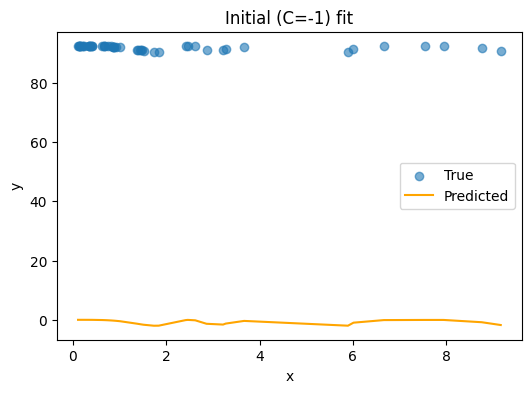

Best C for dataset 0: 91.41999999994466


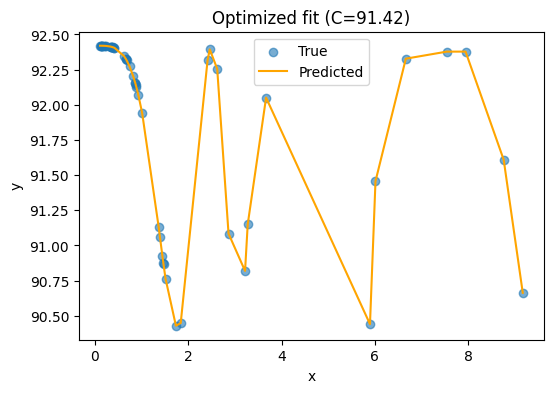

In [24]:
import numpy as np
import sympy
from scipy.optimize import minimize_scalar

# Define symbolic variables globally if used across functions
C, y, x1, x2, x3, x4, x5, x6 = sympy.symbols('C, y, x1, x2, x3, x4, x5, x6', real=True, positive=True)

def load_dataset(index, nb_zfill, path_data):
    """Load and return the dataset with y and x1 filled."""
    raw = np.load(f'{path_data}/values/data_{str(index).zfill(nb_zfill)}.npy')
    y_vals = raw[:, 0]
    x1_vals = raw[:, 1]

    dataset = np.zeros((raw.shape[0], 7))
    dataset[:, 0] = y_vals
    dataset[:, 1] = x1_vals
    return y_vals, x1_vals, dataset

def predict_expression(dataset):
    """Evaluate the symbolic model for a given dataset."""
    sym_expr, str_expr = evaluate(dataset)
    print("Predicted expression:", str_expr)
    return sym_expr, str_expr

def evaluate_with_constant(expr, x_vals, c_val):
    """Evaluate expression as function of x1 and constant C."""
    f = sympy.lambdify((x1, C), expr, "numpy")
    return f(x_vals, c_val)

def optimize_constant(expr, x_vals, y_vals):
    """Optimize the constant C in the symbolic expression."""
    f = sympy.lambdify((x1, C), expr, "numpy")
    def mse(c_val): return np.mean((f(x_vals, c_val) - y_vals)**2)
    result = minimize_scalar(mse)
    return result.x

def process_and_plot(index, path_data, nb_zfill):
    """Full pipeline: load data, predict, optimize, plot."""
    y_vals, x1_vals, dataset = load_dataset(index, nb_zfill, path_data)

    # Predict symbolic equation
    expr, _ = predict_expression(dataset)

    # Initial fit with C = -1
    y_pred_initial = evaluate_with_constant(expr, x1_vals, c_val=-1)
    plot_true_vs_pred(x1_vals, y_vals, y_pred_initial, title="Initial (C=-1) fit")

    # Optimize C
    best_C = optimize_constant(expr, x1_vals, y_vals)
    print(f"Best C for dataset {index}:", best_C)

    # Final fit
    y_pred_optimized = evaluate_with_constant(expr, x1_vals, best_C)
    plot_true_vs_pred(x1_vals, y_vals, y_pred_optimized, title=f"Optimized fit (C={best_C:.2f})")

# Example usage
process_and_plot(index=0, path_data=PATH_DATA, nb_zfill=NB_ZFILL)


Ground truth tokens for dataset 1: ['add', 'C=-41.81', 'cos', 'sq', 'x1']
Predicted expression (dataset 1): (C)+(1/(log(x1)))
Optimized C for Dataset 1: -41.04193787783515


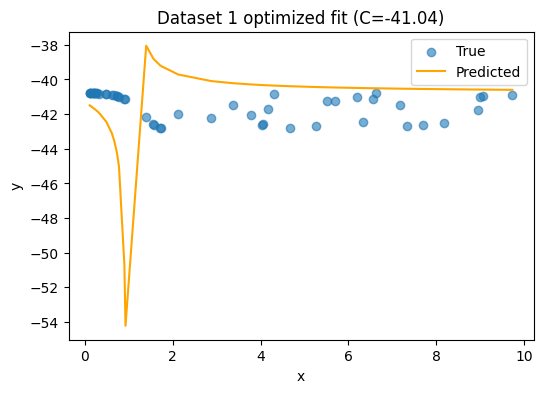

(C + 1/log(x1), '(C)+(1/(log(x1)))', np.float64(-41.04193787783515))

In [30]:
import numpy as np
import sympy
from scipy.optimize import minimize_scalar

# Define symbols
C, y, x1, x2, x3, x4, x5, x6 = sympy.symbols('C, y, x1, x2, x3, x4, x5, x6', real=True, positive=True)

def load_ground_truth(index, path_data, nb_zfill):
    """Load and print ground truth tokens."""
    path = f'{path_data}/ground_truth/equation_{str(index).zfill(nb_zfill)}.txt'
    with open(path) as f:
        tokens = [line.strip() for line in f]
    print(f"Ground truth tokens for dataset {index}:", tokens)
    return tokens

def load_dataset_with_vars(index, path_data, nb_zfill):
    """Load raw dataset and extract y, x1, x2 + build full 7-column dataset."""
    raw = np.load(f'{path_data}/values/data_{str(index).zfill(nb_zfill)}.npy')
    y_vals  = raw[:, 0]
    x1_vals = raw[:, 1]
    x2_vals = raw[:, 2]

    dataset = np.zeros((raw.shape[0], 7))
    dataset[:, 0] = y_vals
    dataset[:, 1] = x1_vals
    dataset[:, 2] = x2_vals

    return y_vals, x1_vals, x2_vals, dataset

def optimize_C_for_expr(expr, x1_vals, x2_vals, y_true, title_prefix):
    """Optimize C and plot prediction using fixed variable names."""
    f = sympy.lambdify((x1, x2, C), expr, "numpy")

    def mse(c_val):
        y_pred = f(x1_vals, x2_vals, c_val)
        return np.mean((y_pred - y_true) ** 2)

    result = minimize_scalar(mse)
    best_C = result.x
    print(f"Optimized C for {title_prefix}:", best_C)

    y_pred_opt = f(x1_vals, x2_vals, best_C)
    plot_true_vs_pred(x1_vals, y_true, y_pred_opt, title=f"{title_prefix} optimized fit (C={best_C:.2f})")

    return best_C

def process_dataset_2var(index, path_data, nb_zfill):
    """Run full pipeline for dataset using x1 and x2 as input vars."""
    _ = load_ground_truth(index, path_data, nb_zfill)
    y, x1_, x2_, dataset = load_dataset_with_vars(index, path_data, nb_zfill)

    sympy_pred, string_pred = evaluate(dataset)
    print(f"Predicted expression (dataset {index}):", string_pred)

    best_C = optimize_C_for_expr(sympy_pred, x1_, x2_, y, title_prefix=f"Dataset {index}")
    return sympy_pred, string_pred, best_C

# Example usage
process_dataset_2var(index=1, path_data=PATH_DATA, nb_zfill=NB_ZFILL)
